In [1]:
import pandas as pd
import numpy as np

In [3]:
import torch
import torch.nn as nn

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [11]:
df = pd.DataFrame(np.linspace(-20, 20, 2000), columns=['x'])
df['y'] = np.sin(df['x']) / df['x'] - (df['x'] / 10)
df.head()

,x,y
0,-20.00000,2.045647
1,-19.97999,2.043274
2,-19.95998,2.040882
3,-19.93997,2.038471
4,-19.91996,2.036042


In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

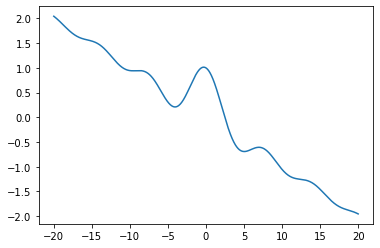

In [13]:
plt.plot(df['x'], df['y'])
plt.show()

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  # Если мы создаем последовательность слоев - то мы задаем их
                                                     # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  # Эта строчка означает тоже самое что и
                                                         # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),  # Звездочка означает unpacking списка  
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        #img = img.reshape(-1, *img_shape)
        return img

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        #img_flat = img.reshape(img.size(0), -1)
        validity = self.model(img)
        return validity

In [25]:
n_epochs = 20  # количество эпох
lr = 0.0002  # шаг обучения
batch_size = 32
b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 100  # Размерность случайного вектора, который подается на вход генератору

sample_interval = 500  # количество итераций для отображения процесса обучения

In [21]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [22]:
d_loss_history = []
g_loss_history = []

In [32]:
real_data = torch.utils.data.DataLoader(
    df.to_numpy(), # to_numpy()
    batch_size=batch_size,
    shuffle=True)

In [37]:
from torch.autograd import Variable
from IPython import display

[Epoch 15/20] [Batch 55/63]|[D loss: 0.11202990263700485] [G loss: 2.449949026107788]


<Figure size 432x288 with 0 Axes>

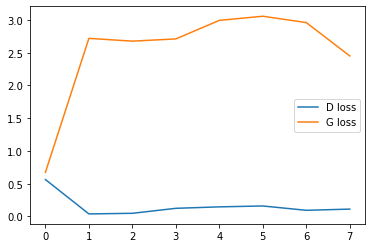

In [42]:
for epoch in range(n_epochs):
    for i, data in enumerate(real_data):
        
        cur_batch_size = len(data)

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        # valid = Variable(torch.FloatTensor(cur_batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        # fake = Variable(torch.FloatTensor(cur_batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        # истинные значения
        valid = torch.FloatTensor(cur_batch_size, 1).fill_(1.0).to(device)
        # ложные значения
        fake = torch.FloatTensor(cur_batch_size, 1).fill_(0.0).to(device)

        # генерация шума (нормальное распределение тут не подойдёт)
        z = Variable(torch.FloatTensor(np.random.uniform(-50, 50, (cur_batch_size, latent_dim)))).to(device)
        
        # реальные значения перекладываем на устройство
        real_ex = Variable(data.type(torch.FloatTensor)).to(device)

        # Генерируем данные Генератором на основе шума
        gen_data = generator(z)


######################  Тренировка дискриминатора    ##########################

        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_ex)

        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        # получаем бинарную кросс-энтропию
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор
        fake_pred = discriminator(gen_data.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        # обновляем градиенты
        optimizer_D.zero_grad()
        
        # подсчёт градиентов
        d_loss.backward()
        
        # шаг оптимизации
        optimizer_D.step()
        
######################  Тренировка генератора    ##########################

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)
        
        # Тут сравниваем предсказанные значения Дискриминатора 
        # (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)


        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)

                #generated_samples = gen_points.detach().cpu()
                #plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(real_data)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 


                # display.display(plt.gcf())
                plt.show()
                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.show()     